# Tesla Stock Price Prediction using XGBoost and LSTM
This notebook implements the two primary models (XGBoost and LSTM) used in the thesis **'NOVEL ARTIFICIAL INTELLIGENCE METHODS FOR TESLA STOCK PREDICTION: INTEGRATING TECHNICAL AND SOCIAL MEDIA DATA'**.

**Instructions:** Please ensure you have the necessary libraries installed (pandas, numpy, matplotlib, xgboost, tensorflow, scikit-learn) before running the cells.

The analysis strictly adheres to a chronological train-test split to prevent data leakage, ensuring the integrity of the time-series prediction results.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

## 1. Setup and Data Loading

In [3]:
from google.colab import files
import pandas as pd
import os

files.upload()

# پیدا کردن خودکار فایل CSV
FILE_PATH = os.path.join(
    '/content',
    [f for f in os.listdir('/content') if f.endswith('.csv')][0]
)

TARGET_COLUMN = 'Price'
TEST_SIZE_RATIO = 0.2
LOOKBACK_WINDOW = 10

df = pd.read_csv(FILE_PATH)

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# انتخاب فیچرها
feature_cols = [c for c in df.columns if c not in ['Date', TARGET_COLUMN]]

# پر کردن NaNها
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].mean())

print("Data Shape:", df.shape)
print("Target:", TARGET_COLUMN)
print("Features:", len(feature_cols))


Saving tesla_stock_with_updated_price (1) (1).csv to tesla_stock_with_updated_price (1) (1) (2).csv
Data Shape: (1128, 38)
Target: Price
Features: 36


## 2. Evaluation Function

In [4]:
def evaluate_model(y_true, y_pred, model_name):
    """Calculates and prints evaluation metrics."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n--- {model_name} Evaluation ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R-squared (R2): {r2:.4f}")

    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

## 3. Chronological Train-Test Split (Preventing Data Leakage)

In [5]:
split_index = int(len(df) * (1 - TEST_SIZE_RATIO))
df_train = df.iloc[:split_index]
df_test = df.iloc[split_index:]

X_train_full = df_train[feature_cols]
X_test_full = df_test[feature_cols]
y_train = df_train[TARGET_COLUMN]
y_test = df_test[TARGET_COLUMN]

print(f"\nTrain set size: {len(X_train_full)} samples (up to Date: {df_train['Date'].iloc[-1].date()})")
print(f"Test set size: {len(X_test_full)} samples (from Date: {df_test['Date'].iloc[0].date()})")


Train set size: 902 samples (up to Date: 2018-12-24)
Test set size: 226 samples (from Date: 2018-12-26)


## 4. Model 1: XGBoost Regressor

In [6]:
print("\n" + "="*50)
print("Starting XGBoost Model Training")
print("="*50)

# XGBoost does not require feature scaling
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_full, y_train)
y_pred_xgb = xgb_model.predict(X_test_full)

xgb_results = evaluate_model(y_test, y_pred_xgb, "XGBoost Regressor")


Starting XGBoost Model Training

--- XGBoost Regressor Evaluation ---
RMSE: 0.9289
MAE: 0.3121
R-squared (R2): 0.9422


## 5. Model 2: LSTM Network

In [7]:
# ===============================
# LSTM MODEL - FULL FIXED VERSION
# ===============================

import numpy as np
import pandas as pd
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping


print("\n" + "="*50)
print("Starting LSTM Model Training")
print("="*50)


# -------------------------------
# Helper functions
# -------------------------------
def create_sequences(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i - lookback:i, :])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)


def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

    return {
        "Model": model_name,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    }


# -------------------------------
# Parameters (already defined before)
# -------------------------------
# TARGET_COLUMN = 'Price'
# LOOKBACK_WINDOW = 10
# feature_cols = ...
# split_index = ...
# df = ...


# -------------------------------
# Scaling
# -------------------------------
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(df[feature_cols])

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(df[TARGET_COLUMN].values.reshape(-1, 1))


# -------------------------------
# Create sequences
# -------------------------------
X_seq_full, y_seq_full = create_sequences(
    X_scaled,
    y_scaled,
    LOOKBACK_WINDOW
)


# -------------------------------
# Chronological split (CRITICAL FIX)
# -------------------------------
split_seq_index = split_index - LOOKBACK_WINDOW

X_train_seq = X_seq_full[:split_seq_index]
X_test_seq  = X_seq_full[split_seq_index:]

y_train_seq = y_seq_full[:split_seq_index]
y_test_seq  = y_seq_full[split_seq_index:]


print(f"LSTM Train set size: {len(X_train_seq)} samples")
print(f"LSTM Test  set size: {len(X_test_seq)} samples")


# -------------------------------
# Build LSTM model (BEST PRACTICE)
# -------------------------------
lstm_model = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)


# -------------------------------
# Train model
# -------------------------------
early_stop = EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = lstm_model.fit(
    X_train_seq,
    y_train_seq,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)


# -------------------------------
# Prediction & inverse scaling
# -------------------------------
y_pred_scaled_lstm = lstm_model.predict(X_test_seq, verbose=0)

y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled_lstm)
y_test_lstm_original = scaler_y.inverse_transform(y_test_seq)


# -------------------------------
# Evaluation (NO LENGTH ERROR)
# -------------------------------
lstm_results = evaluate_model(
    y_test_lstm_original,
    y_pred_lstm,
    "LSTM Network"
)



Starting LSTM Model Training
LSTM Train set size: 892 samples
LSTM Test  set size: 226 samples
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0732
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0077
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0051
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0036
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0045
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0038
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025
Epoch 14/100
28/28 ━━━━━━━━━━

## 6. Results Visualization and Comparison


FINAL COMPARATIVE RESULTS TABLE (Metrics for Thesis)
| Model             |     RMSE |      MAE |       R2 |
|:------------------|---------:|---------:|---------:|
| XGBoost Regressor | 0.928895 | 0.312116 | 0.942213 |
| LSTM Network      | 1.03122  | 0.799587 | 0.928781 |

Results table saved to: /content/model_performance_metrics_raw.csv


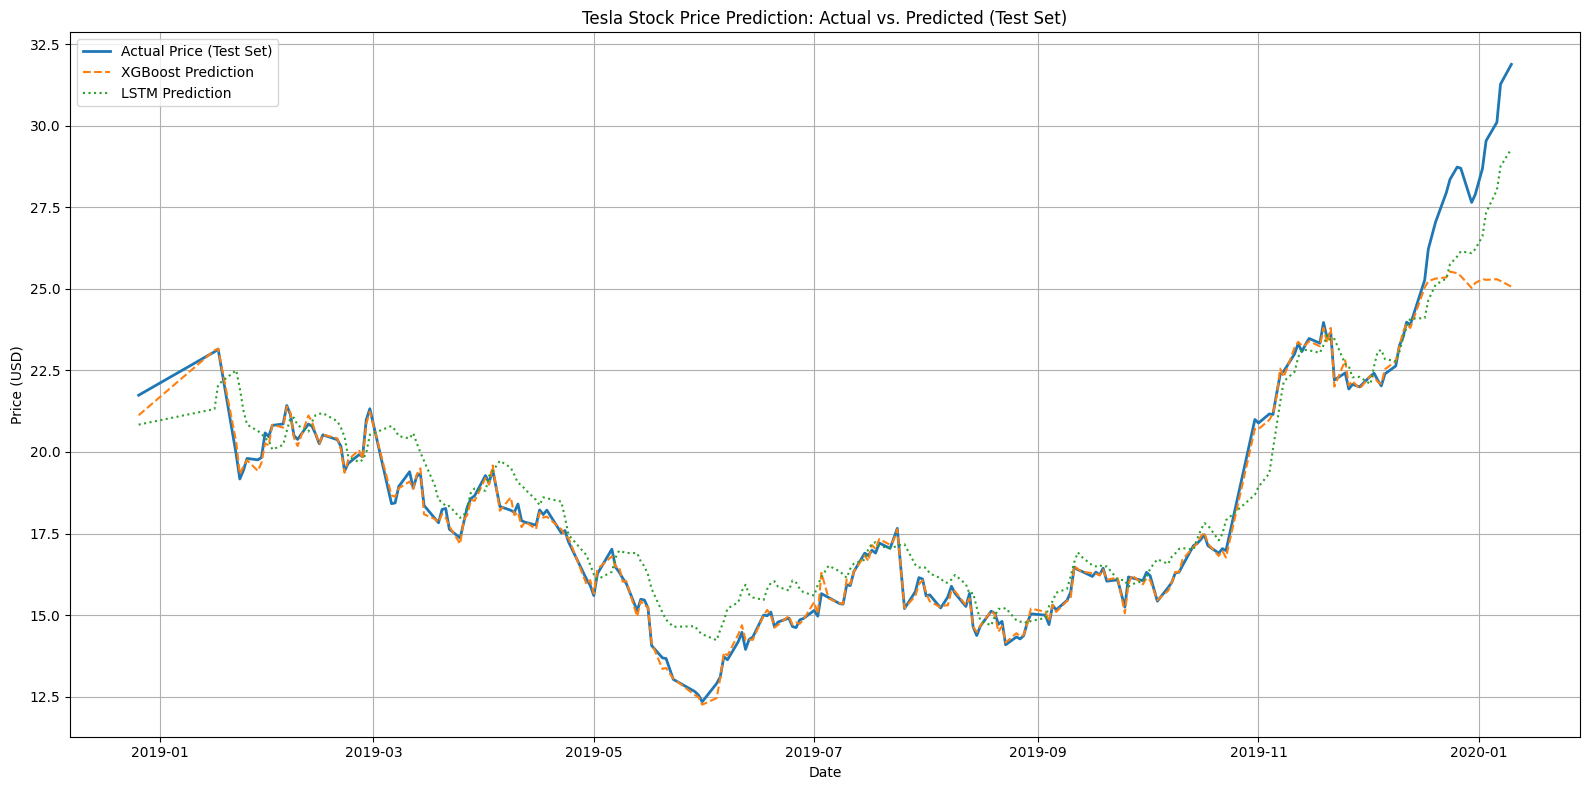

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ===============================
# Final Results Table
# ===============================
all_results = pd.DataFrame([xgb_results, lstm_results])

print("\n" + "="*50)
print("FINAL COMPARATIVE RESULTS TABLE (Metrics for Thesis)")
print("="*50)
print(all_results.to_markdown(index=False))


# ===============================
# Save results (FIXED PATH)
# ===============================
RESULTS_CSV_PATH = "/content/model_performance_metrics_raw.csv"
PLOT_PATH = "/content/prediction_comparison.png"

all_results.to_csv(RESULTS_CSV_PATH, index=False)
print(f"\nResults table saved to: {RESULTS_CSV_PATH}")


# ===============================
# Plot comparison
# ===============================
plt.figure(figsize=(16, 8))

# Correctly aligned dates for LSTM
test_dates_lstm = df['Date'].iloc[
    split_index : split_index + len(y_test_lstm_original)
]

# Actual prices
plt.plot(
    test_dates_lstm,
    y_test_lstm_original.flatten(),
    label='Actual Price (Test Set)',
    linewidth=2
)

# XGBoost prediction (aligned)
plt.plot(
    test_dates_lstm,
    y_pred_xgb[-len(test_dates_lstm):],
    label='XGBoost Prediction',
    linestyle='--'
)

# LSTM prediction
plt.plot(
    test_dates_lstm,
    y_pred_lstm.flatten(),
    label='LSTM Prediction',
    linestyle=':'
)

plt.title('Tesla Stock Price Prediction: Actual vs. Predicted (Test Set)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("/content/prediction_comparison.png", dpi=300)
plt.show()
